In [1]:
import os
import cv2
from glob import glob

import numpy as np 
import imutils

import matplotlib.pyplot as plt
from matplotlib.image import imread 

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline


In [2]:
image_shape  = (64,64,1)
train_path = r"C:\Users\Hp\FP\Blink Detection\Dataset Blink\Train"
test_path  = r"C:\Users\Hp\FP\Blink Detection\Dataset Blink\Test"
folders=glob(test_path + '/*')
len(folders)

2

In [3]:
os.listdir(train_path)

['Closed', 'Opened']

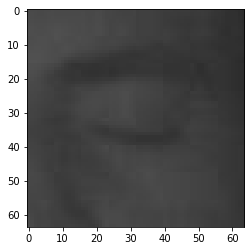

In [4]:
path = (train_path+'\\Closed\\'+'Closed_2.jpg')
img = cv2.imread(path)

plt.imshow(imutils.opencv2matplotlib(img))
plt.show()

In [5]:
traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1/255.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode='nearest'
                              )

testdata_gen=ImageDataGenerator(
                             
                             rescale=1./255)

In [6]:
traindata_gen.flow_from_directory(train_path)

Found 18766 images belonging to 2 classes.


In [7]:
model = tf.keras.Sequential([ 
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(len(folders), activation ='softmax') 
])

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [10]:
batch_size = 32
traning_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical')

Found 18766 images belonging to 2 classes.


In [11]:
testing_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 4692 images belonging to 2 classes.


In [12]:
testing_set.class_indices

{'Closed': 0, 'Opened': 1}

In [13]:
result = model.fit(
  traning_set,
  epochs=8,
  validation_data=testing_set,
  callbacks=[early_stop]
)

Epoch 1/8
587/587 [==============================] - 117s 199ms/step - loss: 0.2984 - accuracy: 0.8757 - val_loss: 0.0658 - val_accuracy: 0.9776
Epoch 2/8
587/587 [==============================] - 110s 188ms/step - loss: 0.1066 - accuracy: 0.9642 - val_loss: 0.0453 - val_accuracy: 0.9855
Epoch 3/8
587/587 [==============================] - 111s 190ms/step - loss: 0.0812 - accuracy: 0.9737 - val_loss: 0.0481 - val_accuracy: 0.9866
Epoch 4/8
587/587 [==============================] - 109s 186ms/step - loss: 0.0753 - accuracy: 0.9763 - val_loss: 0.0505 - val_accuracy: 0.9868


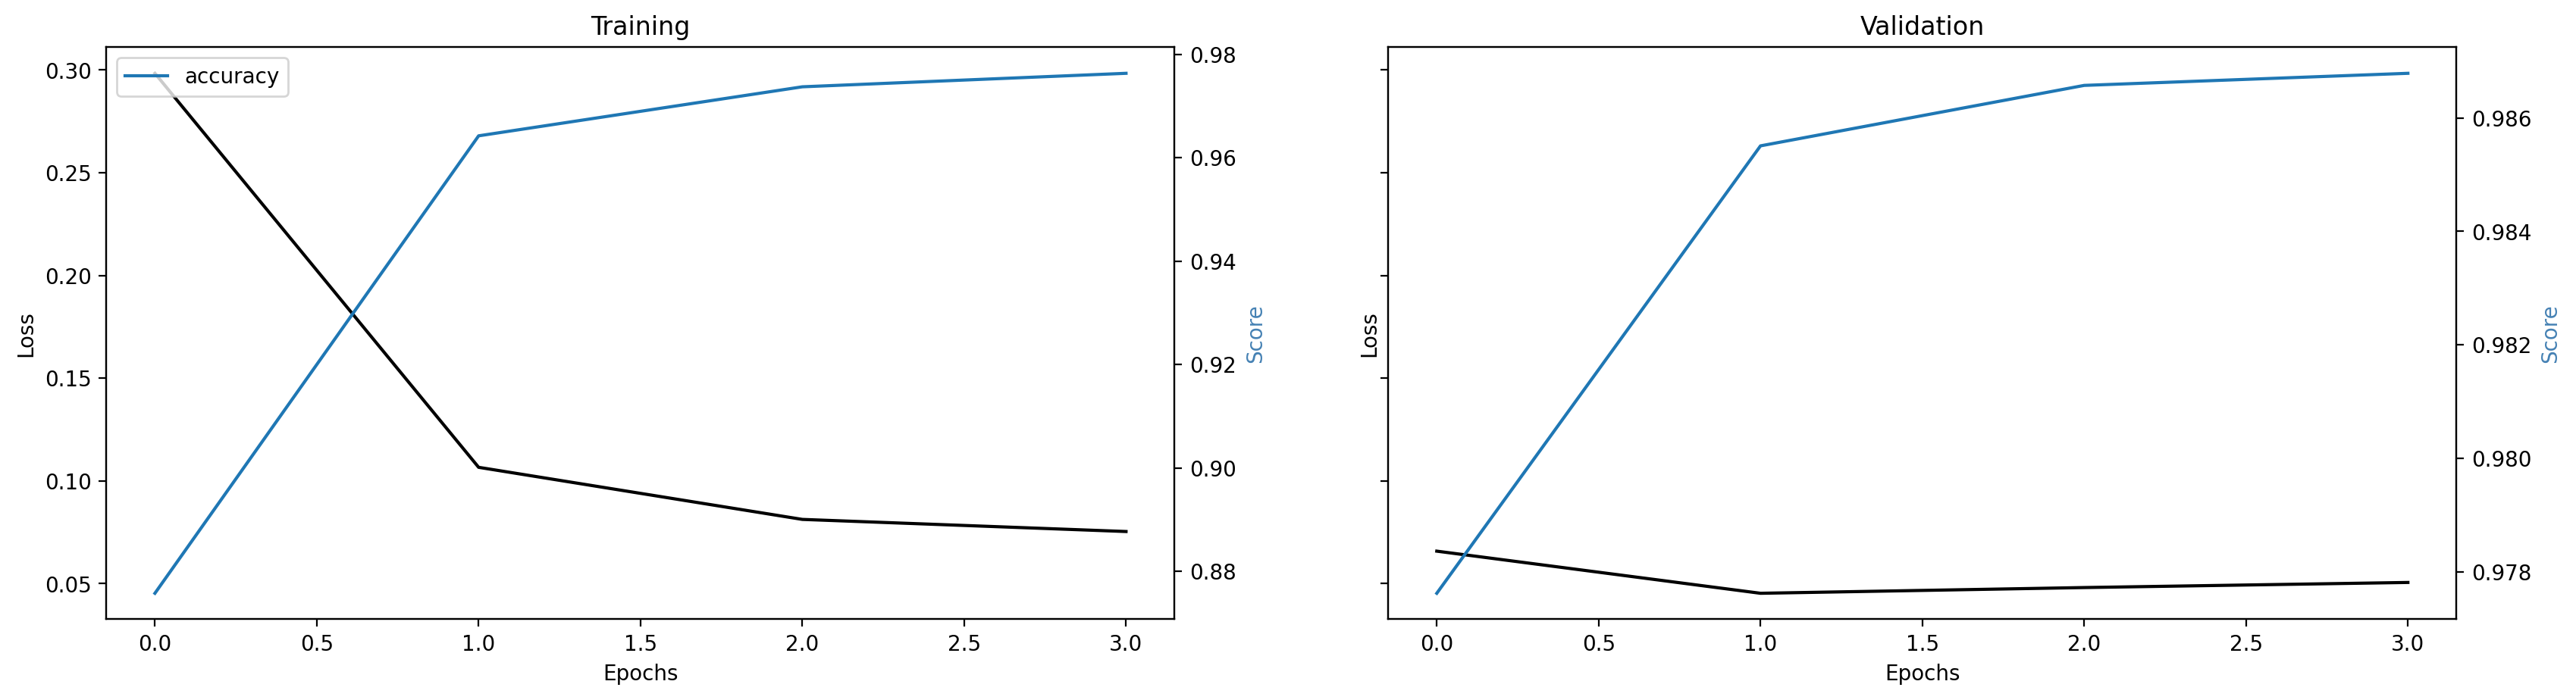

In [14]:
metrics = [k for k in result.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True , figsize=(20,5) , dpi = 200)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(result.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(result.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(result.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(result.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()